<a href="https://colab.research.google.com/github/khangsheng1/PyTorch-Tutorial/blob/main/CIFAR10_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

In [8]:
# Load and normalize CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


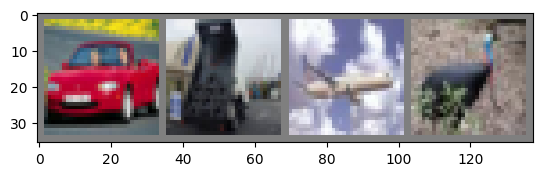

car   truck plane bird 


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
# Define CNN
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

In [11]:
# Define a Loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
import time
start_time = time.time()

# Train CNN
size = len(trainloader)

for epoch in range(5):  # loop over the dataset multiple times
  print(f"Epoch {epoch+1}\n-------------------------------")

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # print statistics
    running_loss += loss.item()
    if i % 1999 == 0:    # print every 2000 mini-batches
      loss, current = loss.item(), (i + 1) * len(trainloader)
      print(f'[{i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0
      run_time = time.time() - start_time
      print(f'Run Time: {run_time/60} minutes.')

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch 1
-------------------------------
[    1] loss: 0.001
Run Time: 0.0013546069463094075 minutes.
[ 2000] loss: 1.873
Run Time: 0.21710095008214314 minutes.
[ 3999] loss: 1.596
Run Time: 0.4342127760251363 minutes.
[ 5998] loss: 1.482
Run Time: 0.6450024326642354 minutes.
[ 7997] loss: 1.440
Run Time: 0.8642646710077921 minutes.
[ 9996] loss: 1.413
Run Time: 1.1245689034461974 minutes.
[11995] loss: 1.384
Run Time: 1.340718420346578 minutes.
Epoch 2
-------------------------------
[    1] loss: 0.001
Run Time: 1.3931920925776164 minutes.
[ 2000] loss: 1.300
Run Time: 1.6157257000605265 minutes.
[ 3999] loss: 1.247
Run Time: 1.8274567047754924 minutes.
[ 5998] loss: 1.256
Run Time: 2.042114559809367 minutes.
[ 7997] loss: 1.244
Run Time: 2.255718406041463 minutes.
[ 9996] loss: 1.227
Run Time: 2.467604732513428 minutes.
[11995] loss: 1.233
Run Time: 2.6768704056739807 minutes.
Epoch 3
-------------------------------
[    1] loss: 0.001
Run Time: 2.726900831858317 minutes.
[ 2000] los

In [13]:
# Save our model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

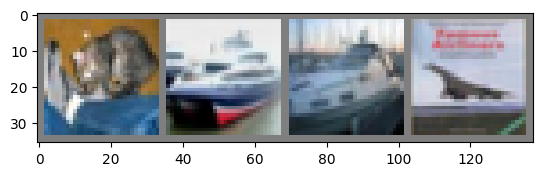

GroundTruth:  cat   ship  ship  plane


In [14]:
# Test model
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [15]:
# Load in saved model
model = Net()
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [16]:
# Test above images
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  ship  ship  ship  ship 


In [17]:
# Test the rest of test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [18]:
# See what data performed well
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 54.3 %
Accuracy for class: car   is 77.2 %
Accuracy for class: bird  is 49.1 %
Accuracy for class: cat   is 46.6 %
Accuracy for class: deer  is 58.0 %
Accuracy for class: dog   is 40.4 %
Accuracy for class: frog  is 66.5 %
Accuracy for class: horse is 68.1 %
Accuracy for class: ship  is 82.8 %
Accuracy for class: truck is 63.7 %
